# Classical Shadows in Pauli Basis

## Overview

[Classical shadows](https://www.nature.com/articles/s41567-020-0932-7) formalism is an efficient method to estimate multiple observables. In this tutorial, we will show how to use the `shadows` module in `TensorCircuit` to implement classic shadows in Pauli basis.

Let's first briefly review the classical shadows in Pauli basis. For an $n$-qubit quantum state $\rho$, we randomly perform Pauli projection measurement on each qubit and obtain a snapshot like $\{1,-1,-1,1,\cdots,1,-1\}$. This process is equivalent to apply a random unitary $U$ to $\rho$ and measure in computational basis to obtain $|b\rangle=|s_1\cdots s_n\rangle,\ s_j\in\{0,1\}$:
$$
\begin{equation}
    \rho\rightarrow U\rho U^{\dagger}\xrightarrow{measure}|b\rangle\langle b|,
\end{equation}
$$
where $U=\bigotimes_{j=1}^{n}u_j$, $u_i\in\{H, HS^{\dagger}, \mathbb{I}\}$ correspond to the projection measurements of Pauli $X$, $Y$, $Z$ respectively. Then we reverse the operation to get the equivalent measurement result on $\rho$:
$$
\begin{equation}
    \rho\xrightarrow{measure}U^{\dagger}|b\rangle\langle b| U.
\end{equation}
$$
Moreover, we perform $N$ random measurements and view their average as a quantum channel:
$$
\begin{equation}
    \mathbb{E}\left[U^{\dagger}|b\rangle\langle b|U\right]=\mathcal{M}(\rho),
\end{equation}
$$
we can invert the channel to get the approximation of $\rho$:
$$
\begin{equation}
    \rho=\mathbb{E}\left[\mathcal{M}^{-1}(U^{\dagger}|b\rangle\langle b|U)\right].
\end{equation}
$$
We call each $\rho_i=\mathcal{M}^{-1}(U_i^{\dagger}|b_i\rangle\langle b_i|U_i)$ a shadow snapshot state and their ensemble $S(\rho;N)=\{\rho_i|i=1,\cdots,N\}$ classical shadows.

In Pauli basis, we have a simple expression of $\mathcal{M}^{-1}$:
$$
\begin{eqnarray}
    \rho_i&=&\mathcal{M}^{-1}(U_i^{\dagger}|b_i\rangle\langle b_i|U_i)=\bigotimes_{j=1}^{n}3u_{ij}^{\dagger}|s_{ij}\rangle\langle s_{ij}|u_{ij}-\mathbb{I},\\
    \rho&=&\frac{1}{N}\sum_{i=1}^{N}\rho_i\ .
\end{eqnarray}
$$
For an observable Pauli string $O=\bigotimes_{j=1}^{n}P_j,\ P_j\in\{\mathbb{I}, X, Y, Z\}$, we can directly use $\rho$ to calculate $\langle O\rangle=\text{Tr}(O\rho)$. In practice, we will divide the classical shadows into $K$ parts to calculate the expectation values independently and take the median to avoid the influence of outliers:
$$
\begin{equation}
    \langle O\rangle=\text{median}\{\langle O_{(1)}\rangle\cdots\langle O_{(K)}\rangle\},
\end{equation}
$$
where
$$
\begin{equation}
    \begin{split}
        \langle O_{(k)}\rangle&=\frac{1}{\lceil N/K\rceil}\sum_{i=(k-1)\lceil N/K\rceil+1}^{k\lceil N/K\rceil}\text{Tr}\left[\bigotimes_{j=1}^{n}P_j(3u_{ij}^{\dagger}|s_{ij}\rangle\langle s_{ij}|u_{ij}-\mathbb{I})\right]\\
        &=\frac{1}{\lceil N/K\rceil}\sum_{i=(k-1)\lceil N/K\rceil+1}^{k\lceil N/K\rceil}\prod_{j=1}^n\text{Tr}\left[3P_j u_{ij}^{\dagger}|s_{ij}\rangle\langle s_{ij}|u_{ij}\right].
    \end{split}
\end{equation}
$$

In [24]:
import tensorcircuit as tc
from tensorcircuit import shadows
import numpy as np
from functools import partial
import time
import matplotlib.pyplot as plt

tc.set_backend("jax")
tc.set_dtype("complex128")

('complex128', 'float64')

## Construct the Classical Shadow Snapshots

We first set the number of qubits $n$ and the number of repeated measurements $r$ on each Pauli string. Then from the target observable Pauli strings $\{O_i|i=1,\cdots,M\}$ (0, 1, 2, and 3 correspond to $\mathbb{I}$, $X$, $Y$, and $Z$, respectively), the error $\epsilon$ and the rate of failure $\delta$, we can use `shadow_bound` function to get the total number of snapshots $N$ and the number of equal parts $K$ to split the shadow snapshot states to compute the median of means:
$$
\begin{eqnarray}
    K&=&2\log(2M/\delta),\\
    N&=&K\frac{34}{\epsilon^2}\max_{1\le i\le M}\left\|O_i-\frac{\text{Tr}(O_i)}{2^n}\mathbb{I}\right\|^2_{\text{shadow}}=K\frac{34}{\epsilon^2}3^{\max_{1\le i\le M}k_i},
\end{eqnarray}
$$
where $k_i$ is the number of nontrivial Pauli matrices in $O_i$. Please refer to the Theorem S1 and Lemma S3 in [Huang, Kueng and Preskill (2020)](https://www.nature.com/articles/s41567-020-0932-7) for the details of proof. It should be noted that `shadow_bound` has a certain degree of overestimation of $N$, and so many measurements are not really needed in practice. And `shadow_bound` is not jitable and no need to jit.

In [25]:
n, r = 8, 5
ps = [
    [1, 0, 0, 0, 0, 0, 0, 2],
    [0, 3, 0, 0, 0, 0, 1, 0],
    [0, 0, 2, 0, 0, 3, 0, 0],
    [0, 0, 0, 1, 2, 0, 0, 0],
    [0, 0, 0, 3, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 0],
    [3, 0, 0, 0, 0, 0, 0, 1],
    [0, 2, 0, 0, 0, 0, 3, 0],
    [0, 0, 1, 0, 0, 2, 0, 0],
]

epsilon, delta = 0.1, 0.01
N, K = shadows.shadow_bound(ps, epsilon, delta)
nps = N // r  # number of random selected Pauli strings
print(f"N: {N}\tK: {K}\tnumber of Pauli strings: {nps}")

N: 489600	K: 16	number of Pauli strings: 97920


Then we use random quantum circuit to generate an entangled state.

In [26]:
nlayers = 10
thetas = 2 * np.random.rand(nlayers, n) - 1

c = tc.Circuit(n)
for i in range(n):
    c.H(i)
for i in range(nlayers):
    for j in range(n):
        c.cnot(j, (j + 1) % n)
    for j in range(n):
        c.rz(j, theta=thetas[i, j] * np.pi)

psi = c.state()

We randomly generate Pauli strings. Since the function after just-in-time (jit) compilation does not support random sampling, we need to generate all random states in advance, that is, variable `status`.

In [27]:
pauli_strings = tc.backend.convert_to_tensor(np.random.randint(1, 4, size=(nps, n)))
status = tc.backend.convert_to_tensor(np.random.rand(nps, r))

If `measurement_only`=True, the outputs of `shadow_snapshots` are snapshot bit strings $b=s_1\cdots s_n,\ s_j\in\{0,1\}$, otherwise the outputs are snapshot states $\{u_{j}^{\dagger}|s_j\rangle\langle s_j| u_j\ |j=1,\cdots,n\}$. If you only need to generate one batch of snapshots or generate multiple batches of snapshots with different `nps` or `r`, jit cannot provide speedup. JIT will only accelerate when the same shape of snapshots are generated multiple times.

In [28]:
@partial(tc.backend.jit, static_argnums=(3,))
def shadow_ss(psi, pauli_strings, status, measurement_only=False):
    return shadows.shadow_snapshots(
        psi, pauli_strings, status, measurement_only=measurement_only
    )


ss_states = shadow_ss(psi, pauli_strings, status)  # jit is not necessary here
print("shape of snapshot states:", ss_states.shape)

shape of snapshot states: (97920, 5, 8, 2, 2)


## Estimate the Expectation Values of Observables

Since the operation of taking the median is not jitable, the outputs of `expectation_ps_shadows` have $K$ values, and we need to take the median of them.

In [29]:
def shadow_expec(snapshots_states, ob):
    return shadows.expectation_ps_shadow(snapshots_states, ps=ob, k=K)


sejit = tc.backend.jit(shadow_expec)

It can be seen from the running time that every time the number of Pauli strings changes, `shadow_expec` will be recompiled, but for the same number of Pauli strings but different observables, `shadow_expec` will only be compiled once. In the end, the absolute errors given by classical shadows are much smaller than the $\epsilon=0.1$ we set, so `shadow_bound` gives a very loose upper bound.

observalbe: No.0	number of Pauli strings: 1000	time: 0.9551787376403809
observalbe: No.1	number of Pauli strings: 1000	time: 0.0018684864044189453
observalbe: No.2	number of Pauli strings: 1000	time: 0.0013768672943115234
observalbe: No.3	number of Pauli strings: 1000	time: 0.001379251480102539
observalbe: No.4	number of Pauli strings: 1000	time: 0.0013794898986816406
observalbe: No.5	number of Pauli strings: 1000	time: 0.0013344287872314453
observalbe: No.6	number of Pauli strings: 1000	time: 0.0013382434844970703
observalbe: No.7	number of Pauli strings: 1000	time: 0.0013227462768554688
observalbe: No.8	number of Pauli strings: 1000	time: 0.0013265609741210938
observalbe: No.9	number of Pauli strings: 1000	time: 0.0013682842254638672
observalbe: No.0	number of Pauli strings: 10000	time: 1.0090177059173584
observalbe: No.1	number of Pauli strings: 10000	time: 0.013788700103759766
observalbe: No.2	number of Pauli strings: 10000	time: 0.013601541519165039
observalbe: No.3	number of Paul

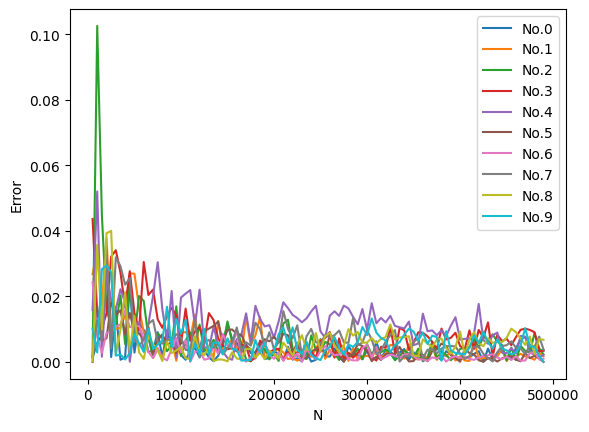

In [30]:
bz = 1000

exact, res = [], []
exact_expec = c.expectation_ps(ps=ps[0])
for ob in ps:
    exact.append(tc.backend.real(c.expectation_ps(ps=ob)))
exact = np.asarray(exact)[:, None]

bzs, res = [], []
for i in range(bz, nps + bz, bz):
    res.append([])
    ss_states_batch = ss_states[:i]
    bzs.append(ss_states_batch.shape[0])
    t0 = time.time()
    for j, ob in enumerate(ps):
        expcs = sejit(ss_states_batch, ob)
        res[-1].append(np.median(expcs))
        t = time.time()
        if i == bz or i % (bz * 10) == 0 or i >= nps:
            print(
                f"observalbe: No.{j}\tnumber of Pauli strings: {bzs[-1]}\ttime: {t - t0}"
            )
        t0 = t
res = np.asarray(res).T
bzs = np.asarray(bzs) * r

error = np.abs(res - exact)
plt.figure()
plt.xlabel("N")
plt.ylabel("Error")
for i, y in enumerate(error):
    plt.plot(bzs, y, label=f"No.{i}")
plt.legend()
plt.show()

## Estimate the Entanglement Entropy

We can also use classical shadows to calculate entanglement entropy. `entropy_shadow` first reconstructs the reduced density matrix, then solves the eigenvalues and finally calculates the entanglement entropy from non-negative eigenvalues. Since the time and space complexity of reconstructing the density matrix is exponential with respect to the system size, this method is only efficient when the reduced system size is constant. `entropy_shadow` is jitable, but it will only accelerate when the reduced sub systems have the same shape.

In [31]:
subs = [
    [1, 4],
    [2, 7],
    [3, 6],
    [0, 5],
    [7, 0],
    [1, 4, 7],
    [0, 3, 6],
    [5, 4, 2],
    [7, 2, 5],
    [0, 1, 2],
]


@tc.backend.jit
def shadow_ent(snapshots_states, sub, alpha=2):
    return shadows.entropy_shadow(snapshots_states, sub=sub, alpha=alpha)


for sub in subs:
    exact_rdm = tc.quantum.reduced_density_matrix(
        psi, cut=[i for i in range(n) if i not in sub]
    )
    exact_ent = tc.quantum.renyi_entropy(exact_rdm, k=2)

    t0 = time.time()
    ent = shadow_ent(ss_states, sub)
    t = time.time()
    print(f"sub: {sub}\ttime: {t - t0}\texact: {exact_ent}\tshadow entropy: {ent}")

sub: [1, 4]	time: 0.18098187446594238	exact: 1.3406660475264627	shadow entropy: 1.336610480903445
sub: [2, 7]	time: 0.03824925422668457	exact: 1.3490932264001985	shadow entropy: 1.3509166994806294
sub: [3, 6]	time: 0.038893938064575195	exact: 1.3078555208559692	shadow entropy: 1.3045157342230482
sub: [0, 5]	time: 0.038709402084350586	exact: 1.3553616203287133	shadow entropy: 1.3522747747844561
sub: [7, 0]	time: 0.03954339027404785	exact: 1.3698051383654024	shadow entropy: 1.3692586760254173
sub: [1, 4, 7]	time: 0.2516930103302002	exact: 1.8458514325863924	shadow entropy: 1.8421843494645114
sub: [0, 3, 6]	time: 0.1100921630859375	exact: 1.868420576333227	shadow entropy: 1.8660364331174333
sub: [5, 4, 2]	time: 0.11081576347351074	exact: 1.9590510433184192	shadow entropy: 1.953652327649616
sub: [7, 2, 5]	time: 0.11055541038513184	exact: 1.886694103128951	shadow entropy: 1.8883320713880314
sub: [0, 1, 2]	time: 0.10973739624023438	exact: 1.8939518969485623	shadow entropy: 1.893886982107739


On the other hand, for the second order Renyi entropy, we have another method to calculate it in polynomial time by random measurements:
$$
\begin{eqnarray}
    S_2&=&-\log\left(\text{Tr}(\rho_A^2)\right),\\
    \text{Tr}(\rho_A^2)&=&2^k\sum_{b,b'\in\{0,1\}^k}(-2)^{-H(b,b')}\overline{P(b)P(b')},
\end{eqnarray}
$$
where $A$ is the $k$-d reduced system, $H(b,b')$ is the Hamming distance between $b$ and $b'$, $P(b)$ is the probability for measuring $\rho_A$ and obtaining the outcomes $b$ thus we need a larger $r$ to obtain a good enough priori probability, and the overline means the average on all random selected Pauli strings. Please refer to [Brydges, et al. (2019)](https://www.science.org/doi/full/10.1126/science.aau4963) for more details. We can use `renyi_entropy_2` to implement this method, but it is not jitable because we need to build the dictionary based on the bit strings obtained by measurements, which is a dynamical process. Compared with `entropy_shadow`, it cannot filter out non-negative eigenvalues, so the accuracy is slightly worse.

In [32]:
nps, r = 1000, 500

pauli_strings = tc.backend.convert_to_tensor(np.random.randint(1, 4, size=(nps, n)))
status = tc.backend.convert_to_tensor(np.random.rand(nps, r))

snapshots = shadows.shadow_snapshots(psi, pauli_strings, status, measurement_only=True)

t0 = time.time()
for sub in subs:
    ent2 = shadows.renyi_entropy_2(snapshots, sub)

    t = time.time()
    print(f"sub: {sub}\ttime: {t - t0}\tshadow entropy 2: {ent2}")
    t0 = t

sub: [1, 4]	time: 3.8456406593322754	shadow entropy 2: 1.311054830562784
sub: [2, 7]	time: 3.859579086303711	shadow entropy 2: 1.3140964084640452
sub: [3, 6]	time: 3.8663485050201416	shadow entropy 2: 1.2798966683162831
sub: [0, 5]	time: 3.8766448497772217	shadow entropy 2: 1.3276919538959406
sub: [7, 0]	time: 3.8847577571868896	shadow entropy 2: 1.339702023736642
sub: [1, 4, 7]	time: 3.9610671997070312	shadow entropy 2: 1.7672210148609153
sub: [0, 3, 6]	time: 3.93074893951416	shadow entropy 2: 1.7792306674701965
sub: [5, 4, 2]	time: 3.928624153137207	shadow entropy 2: 1.8506358171662456
sub: [7, 2, 5]	time: 3.930849313735962	shadow entropy 2: 1.7919769488750392
sub: [0, 1, 2]	time: 3.95222544670105	shadow entropy 2: 1.7900890411701693


## Reconstruct the Density Matrix

We can use `global_shadow_state`, `global_shadow_state1` or `global_shadow_state2` to reconstruct the density matrix. These three functions use different methods, but the results are exactly the same. All functions are jitable, but since we only use each of them once here, they are not wrapped. In terms of implementation details, `global_shadow_state` uses `kron` and is recommended, the other two use `einsum`.

In [33]:
n, nps, r = 2, 10000, 5

c = tc.Circuit(n)
c.H(0)
c.cnot(0, 1)

psi = c.state()
bell_state = psi[:, None] @ psi[None, :]

pauli_strings = tc.backend.convert_to_tensor(np.random.randint(1, 4, size=(nps, n)))
status = tc.backend.convert_to_tensor(np.random.rand(nps, r))
lss_states = shadows.shadow_snapshots(psi, pauli_strings, status)
sdw_state = shadows.global_shadow_state(lss_states)
sdw_state1 = shadows.global_shadow_state1(lss_states)
sdw_state2 = shadows.global_shadow_state2(lss_states)

print("exact:\n", bell_state)
print(f"\nshadow state: error: {np.linalg.norm(bell_state - sdw_state)}\n", sdw_state)
print(
    f"\nshadow state 1: error: {np.linalg.norm(bell_state - sdw_state)}\n", sdw_state1
)
print(
    f"\nshadow state 2: error: {np.linalg.norm(bell_state - sdw_state)}\n", sdw_state2
)

exact:
 [[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]

shadow state: error: 0.029270951470698747
 [[ 0.50035 +0.j       -0.000615+0.000525j  0.001155-0.005205j
   0.49455 +0.00243j ]
 [-0.000615-0.000525j -0.00581 +0.j       -0.0054  -0.00693j
   0.004935-0.000345j]
 [ 0.001155+0.005205j -0.0054  +0.00693j  -0.01259 +0.j
   0.001185+0.001245j]
 [ 0.49455 -0.00243j   0.004935+0.000345j  0.001185-0.001245j
   0.51805 +0.j      ]]

shadow state 1: error: 0.029270951470698747
 [[ 0.50035 +0.j       -0.000615+0.000525j  0.001155-0.005205j
   0.49455 +0.00243j ]
 [-0.000615-0.000525j -0.00581 +0.j       -0.0054  -0.00693j
   0.004935-0.000345j]
 [ 0.001155+0.005205j -0.0054  +0.00693j  -0.01259 +0.j
   0.001185+0.001245j]
 [ 0.49455 -0.00243j   0.004935+0.000345j  0.001185-0.001245j
   0.51805 +0.j      ]]

shadow state 2: error: 0.029270951470698747
 [[ 0.50035 +0.j       -0.000615+0.000525j  0.00

In [34]:
tc.about()

OS info: Linux-5.4.119-1-tlinux4-0010.2-x86_64-with-glibc2.28
Python version: 3.10.11
Numpy version: 1.23.5
Scipy version: 1.11.0
Pandas version: 2.0.2
TensorNetwork version: 0.4.6
Cotengra version: 0.2.1.dev15+g120379e
TensorFlow version: 2.12.0
TensorFlow GPU: []
TensorFlow CUDA infos: {'cpu_compiler': '/dt9/usr/bin/gcc', 'cuda_compute_capabilities': ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80'], 'cuda_version': '11.8', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True}
Jax version: 0.4.13
Jax installation doesn't support GPU
JaxLib version: 0.4.13
PyTorch version: 2.0.1
PyTorch GPU support: False
PyTorch GPUs: []
Cupy is not installed
Qiskit version: 0.24.1
Cirq version: 1.1.0
TensorCircuit version 0.10.0
